<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: Data Scientist в Segmento Екатерина Демидова

# <center>Домашнее задание 2. <br> Визуальный анализ данных о публикациях на Хабрахабре</center>

In [1]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()
tweet_tokenizer.tokenize("Heeeello for for Youuuu !!!!!")

['Heeeello', 'for', 'for', 'Youuuu', '!', '!', '!']

In [3]:
 %autosave 0

Autosave disabled


In [4]:
!pip install nltk 

## Загрузка и знакомство с данными

Для работы вам понадобятся данные из нашего учебного конкурса на kaggle [«Прогноз популярности статьи на Хабре»](https://inclass.kaggle.com/c/howpop-habrahabr-favs-lognorm). Файл **`howpop_train.csv`** уже лежит в нашем репозитории в каталоге **`data`**, но его можно скачать и с Kaggle.

In [5]:
df = pd.read_csv('../../data/howpop_train.csv')

In [6]:
df.shape

(134137, 17)

In [7]:
df.head(3).T

,0,1,2
url,https://habrahabr.ru/post/18284/,https://habrahabr.ru/post/18285/,https://habrahabr.ru/post/18286/
domain,habrahabr.ru,habrahabr.ru,habrahabr.ru
post_id,18284,18285,18286
published,2008-01-01 18:19:00,2008-01-01 18:30:00,2008-01-01 18:34:00
author,@Tapac,@DezmASter,@DezmASter
flow,develop,design,design
polling,False,False,False
content_len,4305,7344,8431
title,Новогодний подарок блоггерам — WordPress 2.3.2,"Сумасшедшие яйца, или сервис для отслеживания ...","Сумасшедшие яйца, или сервис для отслеживания ..."
comments,0,1,47


Избавимся сразу от переменных, названия которых заканчиваются на `_lognorm` (нужны для соревнования на Kaggle). Выберем их с помощью `filter()` и удалим `drop`-ом:

In [8]:
df.drop(filter(lambda c: c.endswith('_lognorm'), df.columns), 
        axis = 1,       # axis = 1: столбцы 
        inplace = True) # избавляет от необходимости сохранять датасет

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
post_id,134137.0,181307.054265,81766.350702,18284.0,115565.0,182666.0,257401.0,314088.0
content_len,134137.0,7516.929699,8724.771640,1.0,2179.0,4949.0,9858.0,352471.0
comments,134137.0,39.625994,62.398958,0.0,7.0,19.0,48.0,2266.0
favs,134137.0,71.999866,145.854135,0.0,8.0,27.0,78.0,8718.0
views,134137.0,16631.013084,31479.819691,3.0,2100.0,7600.0,18700.0,1730000.0
votes_plus,133566.0,35.536888,42.461073,0.0,11.0,22.0,45.0,1466.0
votes_minus,133566.0,8.050035,11.398282,0.0,2.0,5.0,10.0,445.0


In [10]:
df.describe(include = ['object', 'bool'] # бинарные и категориальные переменные
           ).T

,count,unique,top,freq
url,134137,134137,https://geektimes.ru/post/146262/,1
domain,134137,2,habrahabr.ru,97048
published,134137,130291,2011-06-14 15:52:00,39
author,97657,22077,@alizar,5292
flow,97048,6,develop,53318
polling,134137,2,False,129412
title,134137,133628,"Интересные события, произошедшие в выходные",56


In [11]:
# настройка внешнего вида графиков в seaborn
sns.set_style("dark")
sns.set_palette("RdBu")
sns.set_context("notebook", font_scale = 1.5, 
                rc = { "figure.figsize" : (15, 5), "axes.titlesize" : 18 })

Столбец **`published`** (время публикации) содержит строки. Чтобы мы могли работать с этими данными как с датой/временем публикации, приведём их к типу `datetime`:

In [12]:
print(df.published.dtype)
df['published'] = pd.to_datetime(df.published, yearfirst = True)
print(df.published.dtype)

object
datetime64[ns]


Создадим несколько столбцов на основе данных о времени публикации:

In [13]:
df['year'] = [d.year for d in df.published]
df['month'] = [d.month for d in df.published]

df['dayofweek'] = [d.isoweekday() for d in df.published]
df['hour'] = [d.hour for d in df.published]
df['day'] = [d.day for d in df.published]

In [14]:
import numpy as np

-----
Теперь Ваша очередь. В каждом пункте предлагается построить картинку и с ее помощью ответить на вопрос в [форме](https://docs.google.com/forms/d/e/1FAIpQLSf3b5OG8zX_nLQBQ-t20c6M5Auz-VUL-yxj8Fm9_o_XWDBTrg/viewform?c=0&w=1). Конечно, можно попытаться ответить на все вопросы только с Pandas, без картинок, но мы советуем Вам потренироваться строить (красивые) визуализации.   

## 1\. В каком месяце (и какого года) было больше всего публикаций?

* март 2016,
* март 2015,
* апрель 2015,
* апрель 2016.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134137 entries, 0 to 134136
Data columns (total 19 columns):
url            134137 non-null object
domain         134137 non-null object
post_id        134137 non-null int64
published      134137 non-null datetime64[ns]
author         97657 non-null object
flow           97048 non-null object
polling        134137 non-null bool
content_len    134137 non-null int64
title          134137 non-null object
comments       134137 non-null int64
favs           134137 non-null int64
views          134137 non-null int64
votes_plus     133566 non-null float64
votes_minus    133566 non-null float64
year           134137 non-null int64
month          134137 non-null int64
dayofweek      134137 non-null int64
hour           134137 non-null int64
day            134137 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(2), int64(10), object(5)
memory usage: 18.5+ MB


In [16]:
df.head()

,url,domain,post_id,published,author,flow,polling,content_len,title,comments,favs,views,votes_plus,votes_minus,year,month,dayofweek,hour,day
0,https://habrahabr.ru/post/18284/,habrahabr.ru,18284,2008-01-01 18:19:00,@Tapac,develop,False,4305,Новогодний подарок блоггерам — WordPress 2.3.2,0,0,236,0.0,0.0,2008,1,2,18,1
1,https://habrahabr.ru/post/18285/,habrahabr.ru,18285,2008-01-01 18:30:00,@DezmASter,design,False,7344,"Сумасшедшие яйца, или сервис для отслеживания ...",1,1,353,1.0,0.0,2008,1,2,18,1
2,https://habrahabr.ru/post/18286/,habrahabr.ru,18286,2008-01-01 18:34:00,@DezmASter,design,False,8431,"Сумасшедшие яйца, или сервис для отслеживания ...",47,72,1200,45.0,5.0,2008,1,2,18,1
3,https://habrahabr.ru/post/18291/,habrahabr.ru,18291,2008-01-02 01:32:00,@Taoorus,design,False,5662,"Сглаживание шрифтов, и субпиксельная отрисовка",102,36,5700,72.0,3.0,2008,1,3,1,2
4,https://geektimes.ru/post/18294/,geektimes.ru,18294,2008-01-02 14:34:00,@dennydo,NaN,False,3706,Почему мне не нравится iPhone,230,6,1400,73.0,15.0,2008,1,3,14,2


In [17]:
df.groupby(['year','month'])['post_id'].count()

year  month
2008  1         435
      2         496
      3         545
      4         597
      5         635
      6         599
      7         674
      8         677
      9         914
      10        712
      11        661
      12        798
2009  1         797
      2         812
      3         890
      4         840
      5         755
      6         733
      7         891
      8         956
      9         955
      10       1021
      11       1084
      12       1049
2010  1        1010
      2        1203
      3        1257
      4        1068
      5        1012
      6        1090
               ... 
2014  5        1193
      6        1237
      7        1372
      8        1228
      9        1408
      10       1595
      11       1462
      12       1694
2015  1        1504
      2        1793
      3        2189
      4        2110
      5        1799
      6        2004
      7        2111
      8        1849
      9        1944
      10       2030
      11

In [18]:
urls = df.pivot_table(
                        index='year',
                        columns='month', 
                        values='post_id', 
                        aggfunc=len)

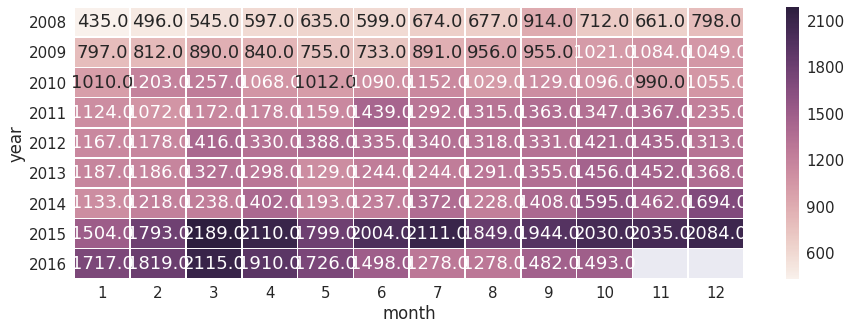

In [19]:
sns.heatmap(urls, annot=True, fmt=".1f", linewidths=.7)

## 2\. Проанализируйте публикации в этом месяце

Выберите один или несколько вариантов:

* На графике не заметны какие-либо выбросы или аномалии,
* Один или несколько дней сильно выделяются из общей картины,
* На хабре _всегда_ больше статей, чем на гиктаймсе,
* По субботам на гиктаймс и на хабрахабр публикуют примерно одинаковое число статей.

Подсказки: постройте график зависимости числа публикаций от дня; используйте параметр `hue`; не заморачивайтесь сильно с ответами и не ищите скрытого смысла :)

In [20]:
data_march = df[(df['year'] == 2015) & (df['month'] == 3)]
data_march.head()

,url,domain,post_id,published,author,flow,polling,content_len,title,comments,favs,views,votes_plus,votes_minus,year,month,dayofweek,hour,day
97666,https://habrahabr.ru/post/251783/,habrahabr.ru,251783,2015-03-01 00:00:00,@SLY_G,develop,False,49647,Введение в разработку слайд-шоу на JavaScript,6,375,42900,15.0,4.0,2015,3,7,0,1
97667,https://habrahabr.ru/company/kolibrios/blog/23...,habrahabr.ru,239033,2015-03-01 00:09:00,NaN,develop,False,8581,Дайджест KolibriOS #7: как мы зиму перезимовали,14,22,17600,36.0,2.0,2015,3,7,0,1
97668,https://habrahabr.ru/post/286286/,habrahabr.ru,286286,2015-03-01 07:13:00,@semen_grinshtein,misc,False,1883,"9 марта компания Apple сделает то, что не дела...",12,3,9300,16.0,4.0,2015,3,7,7,1
97669,https://habrahabr.ru/post/251347/,habrahabr.ru,251347,2015-03-01 07:52:00,@Makeman,develop,False,48658,Context Model Pattern via Aero Framework,6,66,6600,8.0,4.0,2015,3,7,7,1
97670,https://habrahabr.ru/post/251765/,habrahabr.ru,251765,2015-03-01 10:30:00,@Doomer3D,develop,False,40374,Заполнение текстовых шаблонов данными на основ...,4,39,6200,5.0,1.0,2015,3,7,10,1


KeyboardInterrupt: 

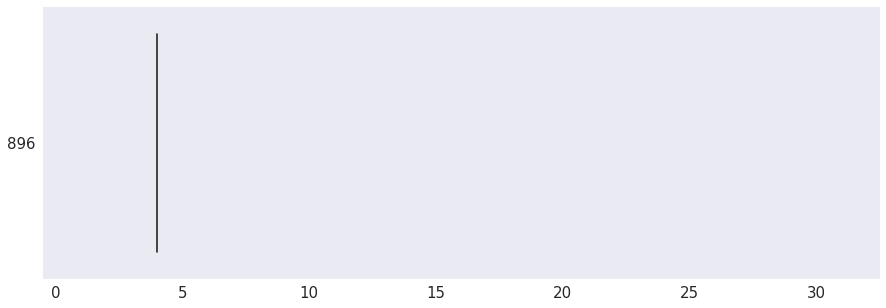

In [32]:
sns.boxplot(y="post_id", x="day", data=data_march, orient="h");

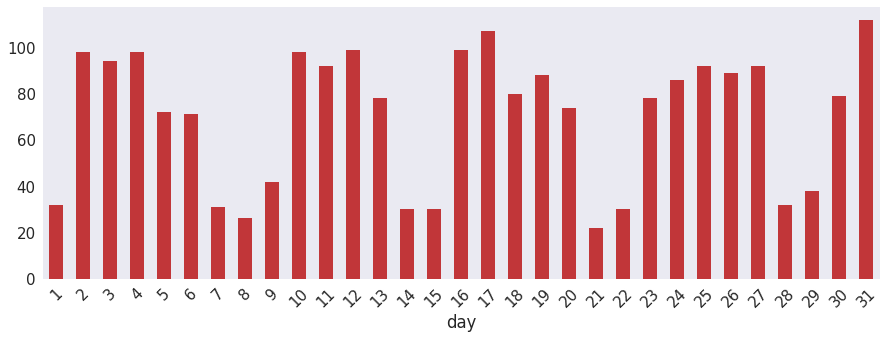

In [22]:
data_march.groupby(['day'])['post_id'].count().plot(kind='bar', rot=45);

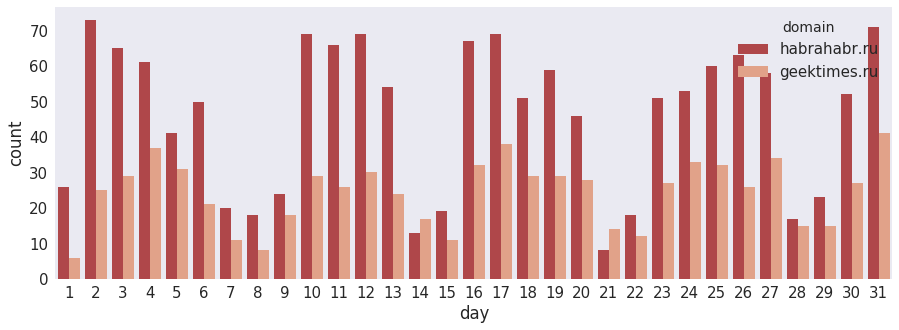

In [24]:
sns.countplot(x='day', hue='domain', data=data_march);

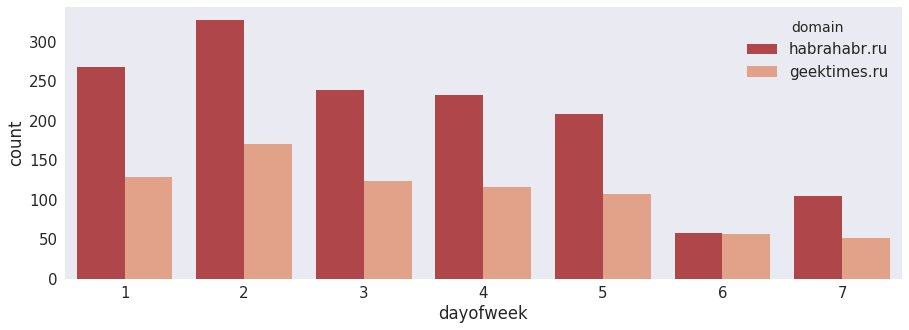

In [25]:
sns.countplot(x='dayofweek', hue='domain', data=data_march);

In [29]:
data_march.groupby(['dayofweek', 'domain'])['url'].count()

dayofweek  domain      
1          geektimes.ru    129
           habrahabr.ru    267
2          geektimes.ru    170
           habrahabr.ru    327
3          geektimes.ru    124
           habrahabr.ru    238
4          geektimes.ru    116
           habrahabr.ru    232
5          geektimes.ru    107
           habrahabr.ru    208
6          geektimes.ru     57
           habrahabr.ru     58
7          geektimes.ru     52
           habrahabr.ru    104
Name: url, dtype: int64

In [30]:
data_march.groupby(['day', 'domain'])['url'].count()

day  domain      
1    geektimes.ru     6
     habrahabr.ru    26
2    geektimes.ru    25
     habrahabr.ru    73
3    geektimes.ru    29
     habrahabr.ru    65
4    geektimes.ru    37
     habrahabr.ru    61
5    geektimes.ru    31
     habrahabr.ru    41
6    geektimes.ru    21
     habrahabr.ru    50
7    geektimes.ru    11
     habrahabr.ru    20
8    geektimes.ru     8
     habrahabr.ru    18
9    geektimes.ru    18
     habrahabr.ru    24
10   geektimes.ru    29
     habrahabr.ru    69
11   geektimes.ru    26
     habrahabr.ru    66
12   geektimes.ru    30
     habrahabr.ru    69
13   geektimes.ru    24
     habrahabr.ru    54
14   geektimes.ru    17
     habrahabr.ru    13
15   geektimes.ru    11
     habrahabr.ru    19
                     ..
17   geektimes.ru    38
     habrahabr.ru    69
18   geektimes.ru    29
     habrahabr.ru    51
19   geektimes.ru    29
     habrahabr.ru    59
20   geektimes.ru    28
     habrahabr.ru    46
21   geektimes.ru    14
     habrahabr.ru     

## 3\. Когда лучше всего публиковать статью?

* Больше всего просмотров набирают статьи, опубликованные в 12 часов дня;
* У опубликованных в 10 утра постов больше всего комментариев;
* Больше всего просмотров набирают статьи, опубликованные в 6 часов утра;
* Максимальное число комментариев на гиктаймсе набрала статья, опубликованная в 9 часов вечера;
* На хабре дневные статьи комментируют чаще, чем вечерние.

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134137 entries, 0 to 134136
Data columns (total 19 columns):
url            134137 non-null object
domain         134137 non-null object
post_id        134137 non-null int64
published      134137 non-null datetime64[ns]
author         97657 non-null object
flow           97048 non-null object
polling        134137 non-null bool
content_len    134137 non-null int64
title          134137 non-null object
comments       134137 non-null int64
favs           134137 non-null int64
views          134137 non-null int64
votes_plus     133566 non-null float64
votes_minus    133566 non-null float64
year           134137 non-null int64
month          134137 non-null int64
dayofweek      134137 non-null int64
hour           134137 non-null int64
day            134137 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(2), int64(10), object(5)
memory usage: 18.5+ MB


In [38]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [46]:
hours_df = df.groupby('hour')[['views']].mean()
hours_df.columns = ['hour']

trace0 = go.Scatter(
    x=hours_df.index,
    y=hours_df.hour,
    name='hour'
)


data = [trace0]
layout = {'title': 'Statistics of views for hours'}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)

In [47]:
hours_df = df.groupby('hour')[['comments']].mean()
hours_df.columns = ['hour']

trace0 = go.Scatter(
    x=hours_df.index,
    y=hours_df.hour,
    name='hour'
)


data = [trace0]
layout = {'title': 'Statistics of comments for hours'}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)

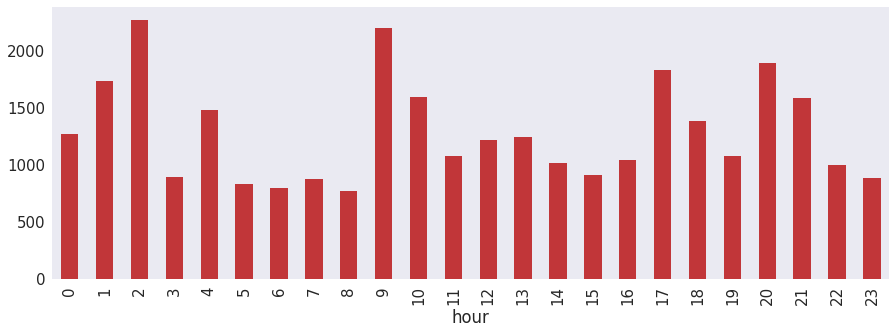

In [50]:
df.groupby(['hour'])['comments'].max().plot(kind='bar')

## 4\. Кого из топ-20 авторов чаще всего минусуют?

* @Mordatyj
* @Mithgol
* @alizar
* @ilya42

In [ ]:
data_authors = df[df.author in ['@Mordatyj', '@Mithgol', '@alizar', '@ilya42']].all()

In [69]:
data_authors = df.groupby(['author'])['votes_minus'].mean()
data_authors

author
@0000168                  6.230769
@004helix                 1.000000
@01000110110010010010    24.000000
@029ah                    1.000000
@03uk                     3.500000
@047                      4.500000
@069056                   5.500000
@0DrYu0                   3.000000
@0dd_b1t                  9.250000
@0decca                   8.666667
@0dmin                   19.166667
@0leGG                   10.285714
@0lgaShulgina             9.000000
@0lorin                   2.000000
@0n1x                     2.666667
@0n1y_0ne                 5.000000
@0nly0ne                 16.333333
@0range                  17.666667
@0serd0                   2.000000
@0serg                    9.333333
@0tt0max                  0.000000
@0ver                    14.000000
@0x0FFF                   2.200000
@0x13                     0.000000
@0x3f00                  16.000000
@0x5cef                   2.000000
@0x62ash                 11.166667
@0x656b694d               5.000000
@0xA0        

In [64]:
for item in ['@Mordatyj', '@Mithgol', '@alizar', '@ilya42']:
    print(data_authors[item])

7.47145488029
20.4810810811
7.92819148936
6.216796875


## 5\. Сравните субботы и понедельники

Правда ли, что по субботам авторы пишут в основном днём, а по понедельникам — в основном вечером?

In [78]:
hours_df = df.groupby(['dayofweek', 'hour'])[['url']].count()
hours_df.columns = ['dayofweek', 'hour']

#trace0 = go.Scatter(
#    x=hours_df.index,
#    y=hours_df[hours_df.dayofweek == 1].hour,
#    name='hour'
#)


#data = [trace0]
#layout = {'title': 'Statistics of comments for hours'}

#fig = go.Figure(data=data, layout=layout)

#iplot(fig, show_link=False)

ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements

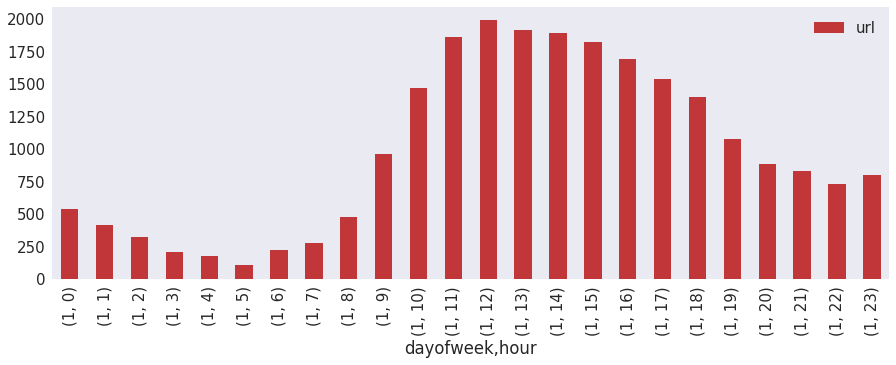

In [92]:
days_hour = df[df.dayofweek == 1].groupby(['dayofweek', 'hour'])[['url']].count()
days_hour.plot(kind='bar')

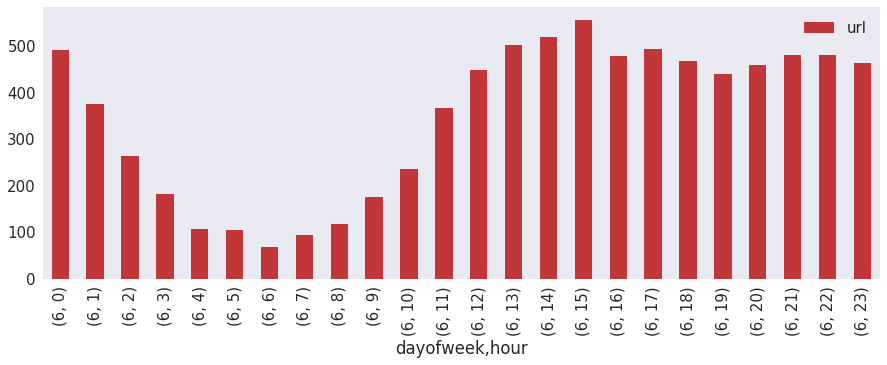

In [93]:
days_hour = df[df.dayofweek == 6].groupby(['dayofweek', 'hour'])[['url']].count()
days_hour.plot(kind='bar')

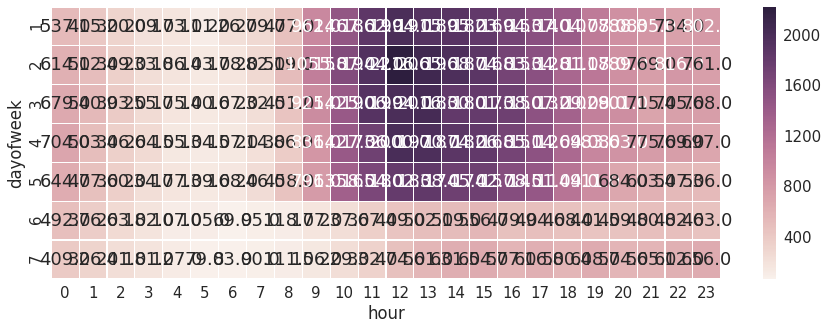

In [83]:
urls = df.pivot_table(
                        index='dayofweek',
                        columns='hour', 
                        values='post_id', 
                        aggfunc=len)

sns.heatmap(urls, annot=True, fmt=".1f", linewidths=.2)